# sKCSD tutorial
In this tutorial we will cover three topics: data format for sKCSD estimation, sKCSD method and source visualization. 

In [1]:
from kcsd import sKCSDcell, sKCSD, sample_data_path
from kcsd import utility_functions as utils
from kcsd.utility_functions import LoadData
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
data_fname = os.path.join(sample_data_path, "gang_7x7_200")

In [3]:
data = LoadData(data_fname)

Load /home/jszmek/kCSD-python/kcsd/../data/gang_7x7_200/morphology/gang_7x7_200_rows_4_cols_5_xmin_-20_xmax_20_ymin_-20_ymax_20_orientation_3.swc
Load /home/jszmek/kCSD-python/kcsd/../data/gang_7x7_200/electrode_positions/elcoord_x_y_z
Load /home/jszmek/kCSD-python/kcsd/../data/gang_7x7_200/LFP/MyLFP


Data should be divided into three subdirectories: morphology, electrode_positions and LFP, each containing one file with morphology, electrode_positions and LFP. LoadData currently supports only swc morphology format. LoadData can read in electrode positions as a text file either with 1 column with x postions for each electrode followed by y postions for each electrodes followed by z positions of each electrode; or a textfile with 3 columns with x, y, z electrode postions.  LFPs should be a text file with appropriate numbers of the shape of n_electrodes x n_time_samples. LoadData also allows for initialization of an empty object and reading in arbitrary data files from specific location using assign function: 
data1 = LoadData()
data1.assign('morphology', path_to_morphology_file)
data1.assign('electrode_positions_file', path_to_electrode_positions_file)
data1.assign('LFP', path_to_LFP_file)

Data used in this tutorial was generated using figures/skcsd_paper/run_LFPy.py (class for running example simulations using LFPy). LFPy uses mV for voltage, ms for time and um for distance (or position). sKCSD (and KCSD) requires data in SI units. That is why data used for sKCSD estimation needs to be scaled.

In [4]:
data.LFP /= 1e3
data.morphology[:, 2:6] /= 1e6
data.ele_pos /= 1e6

Let us visualise the current density.

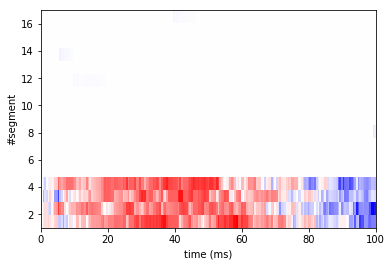

In [5]:
#Other parameters
time = np.loadtxt(os.path.join(data_fname, 'tvec.txt'))
seglen = np.loadtxt(os.path.join(data_fname, 'seglength'))
ground_truth = np.loadtxt(os.path.join(data_fname, 'membcurr'))/seglen[:, None]*1e-3
vmin, vmax =  ground_truth.min(), ground_truth.max()
if abs(vmin) > abs(vmax):
    vmax = abs(vmin)
else:
    vmin = -vmax
fig, ax = plt.subplots(1, 1)
ax.set_aspect('equal')
ax.set_xlabel('time (ms)')
ax.set_ylabel('#segment')
ax.imshow(ground_truth, origin="lower", aspect="auto", interpolation="none", cmap="bwr", vmin=vmin, vmax=vmax, extent=[time[0], time[-1], 1, len(seglen)])


Corresponding voltage in the soma:

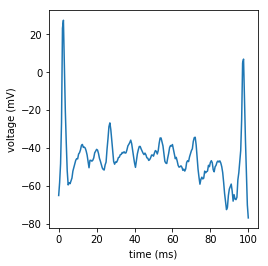

In [6]:
somav = np.loadtxt(os.path.join(data_fname, 'somav.txt'))
fig, ax = plt.subplots(1, 1)
ax.set_aspect('equal')
ax.set_xlabel('time (ms)')
ax.set_ylabel('voltage (mV)')
ax.plot(time, somav)

To calculate sKCSD you must specify the width of the source (R) and noise level (lambd). For neuron morphologies R is going to be of the order of microns. We specified lambd = 10000, which amounts to roughly 10% noise.

In [7]:
n_src = 25
R = 8e-6
lambd = 0.0001
ker = sKCSD(data.ele_pos,
            data.LFP,
            data.morphology,
            n_src_init=n_src,
            src_type='gauss',
            lambd=lambd,
            R_init=R,
            exact=True,
            sigma=0.3)

/home/jszmek/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


skcsd.values(estimate) provides potential and current source density. For potential estimate="POT", for  current density estimate='CSD'. By default skcsd.values() provides CSD.

In [8]:
skcsd = ker.values(transformation="segments")

Both current density and potential are calculated in the 1D space of the morphology loop. sKCSD.values(estimate, transformation) calculates either CSD (estimate="CSD") or potential (estimation="POT") and allows both for transformation to segments and a 3D morphology (for no transformation specify transformation=None). By default (sKCSD.values()) potential and current density are transformed to a 3D cube spanning from (xmin, ymin, zmin) to (xmax, ymax, zmax). To store cell morphology, morphology loop, source positions and allow easy transformations between morphology (segments), morphology loop and 3D cube, sKCSD uses a separate object sKCSDcell. By default sKCSD uses minimum and maximum neuron coordinates from the swc file.

Text(0.5,1,'estimated current density')

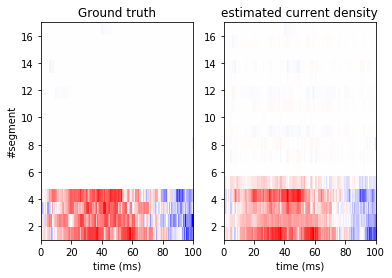

In [9]:
fig, ax = plt.subplots(1, 2)
ax[1].set_aspect('equal')
ax[1].set_xlabel('time (ms)')
ax[1].imshow(skcsd, origin="lower", aspect="auto",
             interpolation="none", cmap="bwr",
             vmin=vmin, vmax=vmax,
             extent=[time[0], time[-1], 1, len(seglen)])
ax[0].set_aspect('equal')
ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('#segment')
ax[0].imshow(ground_truth, origin="lower", aspect="auto",
             interpolation="none", cmap="bwr",
             vmin=vmin, vmax=vmax,
             extent=[time[0], time[-1], 1, len(seglen)])
ax[0].set_title('Ground truth')
ax[1].set_title('estimated current density')


To calculate CSD in the 3D cube:

In [10]:
skcsd_3D =  ker.values(transformation="3D")

To visualize morphology you can use the sKCSD cell object:

In [11]:
morpho_z, extent = ker.cell.draw_cell2D(axis=2)
extent = [extent[-2], extent[-1], extent[0], extent[1]]

draw_cell2D(axis) provides a 2D view of the 3D morphology together with the minimum and maximum coordinates of the 2D view (extent) along a specified axis: 0 for x, 1 for y and 2 for z. Z axis is picked by default. For projections along x-axis extent equals to [ymin, ymax, zmin, zmax], for projections along y-axis extent equals to [xmin, xmax, zmin, zmax], for projections along z-axis extent equals to [xmin, xmax, ymin, ymax].

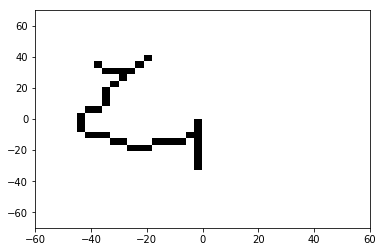

In [17]:
fig, ax = plt.subplots(1, 1)
ax.imshow(morpho_z, origin="lower", aspect="auto", interpolation="none", extent=extent)

Or create a new sKCSDcell object using morphology data and electrode positions:

(30, 21) [-42.7, 0.0, -31.46, 40.95]


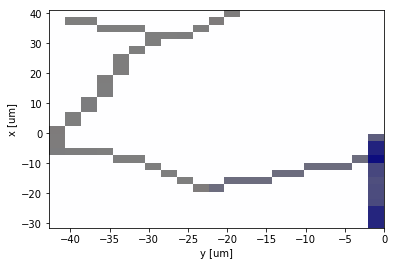

In [13]:
n_src = 100
cell_itself = sKCSDcell(data.morphology, data.ele_pos, n_src)
morpho, extent = cell_itself.draw_cell2D(axis=2)
extent = [extent[-2], extent[-1], extent[0], extent[1]]
extent = [x*1e6 for x in extent]
fig, ax = plt.subplots(1, 1)
ax.imshow(morpho, origin="lower", aspect="auto", interpolation="none", extent=extent)
ax.set_ylabel('x [um]')
ax.set_xlabel('y [um]')
idx = np.where(time == 40)[0][0]
csd = skcsd_3D[:, :, :, idx].sum(axis=(2))
print(csd.shape, extent)
ax.imshow(csd, origin="lower", aspect="auto", interpolation="none", extent=extent, vmin=vmin, vmax=vmax, alpha=.5, cmap=plt.cm.bwr_r)

If sKCSDcell object is created by sKCSD the minimum and maximum 3D coordinates take values of the minimum and maximum coordinates of the morphology. When creating a separate sKCSDcell object one can specify custom xmin, ymin, zmin and xmax, ymax, zmax, which can later be convenient, when plotting CSD and electrode positions. Another useful parameter is tolerance, which specifies minimum width of the voxel (in any direction). By default tolerance is set to 2 um.

In [14]:
tolerance = 3e-6
xmin = data.ele_pos[:, 0].min() - 50e-6
xmax = data.ele_pos[:, 0].max() + 50e-6
ymin = data.ele_pos[:, 1].min() - 40e-6
ymax = data.ele_pos[:, 1].max() + 40e-6
zmin = data.ele_pos[:, 2].min() - 50e-6
zmax = data.ele_pos[:, 2].max() + 50e-6
cell_itself = sKCSDcell(data.morphology, data.ele_pos, n_src,
                        xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax,
                        zmin=zmin, zmax=zmax, tolerance=tolerance)

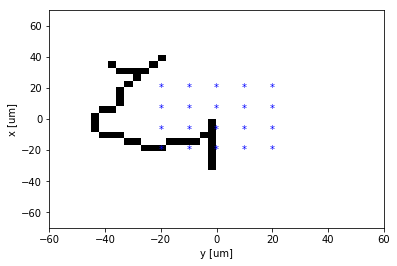

In [15]:
morpho_z, extent = cell_itself.draw_cell2D(axis=2)
extent = [extent[-2], extent[-1], extent[0], extent[1]]
extent = [x*1e6 for x in extent]
fig, ax = plt.subplots(1, 1)
ax.imshow(morpho_z, origin="lower", aspect="auto", interpolation="none", extent=extent)
ax.set_ylabel('x [um]')
ax.set_xlabel('y [um]')
for i in range(len(data.ele_pos)):
    pos_x, pos_y = data.ele_pos[i, 1]*1e6, data.ele_pos[i, 0]*1e6
    ax.text(pos_x, pos_y, '*', ha="center", va="center", color="b")

Let's visualize CSD on top of the morphology in t = 40 ms

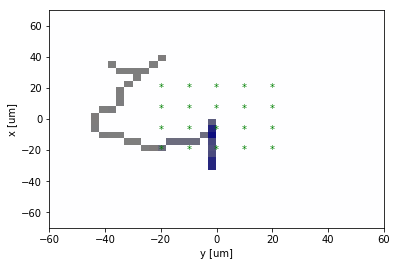

In [22]:
fig, ax = plt.subplots(1, 1)
ax.imshow(morpho_z, origin="lower", aspect="auto", interpolation="none", extent=extent)
ax.set_ylabel('x [um]')
ax.set_xlabel('y [um]')
skcsd = ker.values(transformation=None)
skcsd_3D = cell_itself.transform_to_3D(skcsd)
idx = np.where(time == 40)[0][0]
csd = skcsd_3D[:, :, :, idx].sum(axis=(2))
ax.imshow(csd, origin="lower", aspect="auto", interpolation="none", extent=extent, vmin=vmin, vmax=vmax, alpha=.5, cmap=plt.cm.bwr_r)
ax.set_ylabel('x [um]')
ax.set_xlabel('y [um]')
for i in range(len(data.ele_pos)):
    pos_x, pos_y = data.ele_pos[i, 1]*1e6, data.ele_pos[i, 0]*1e6
    ax.text(pos_x, pos_y, '*', ha="center", va="center", color="g")